<font size="+3" color=DarkBlue><b> <left>CNN Image Classification - Using Intel Image Classification Dataset</u></center></b></font>

<font size="+1" color=DarkBlue><b> <left>(Adaptable to other image classification problems)</u></center></b></font>

# Objective

The aim of this notebook is to demonstrate how to train an image classification model using the Intel Image Classification dataset. A number of the print statements and a lot of the Markup could be dispensed with but are retained here to support learning and understanding. 

The code is based primarily on the FastAI libraries: [FastAI](https://docs.fast.ai/)

Acknowledgement to the following code repository which was used as a starting point: https://www.kaggle.com/code/arbazkhan971/image-classification-using-cnn-94-accuracy

# Notes

* The code base is designed to work on the Microsoft Windows platform, i.e., Windows path separators or back slash are used).
* This notebook was run in Windows 11 Pro x64 OS environment with the following config Processor = 13th Gen Intel(R) Core(TM) i9-13900H, 2600 Mhz, 14 Core(s), 20 Logical Processor(s), Installed Physical Memory (RAM) 64.0 GB. It still takes a few hours to run on the full dataset. See elapsed times in output for an indication.


<a id="1"></a>
<font color="blue" size=+2.5><b>1.1  Typical Convolutional Neural Network (CNN) Architecture</b></font>
<br/>
<br/>
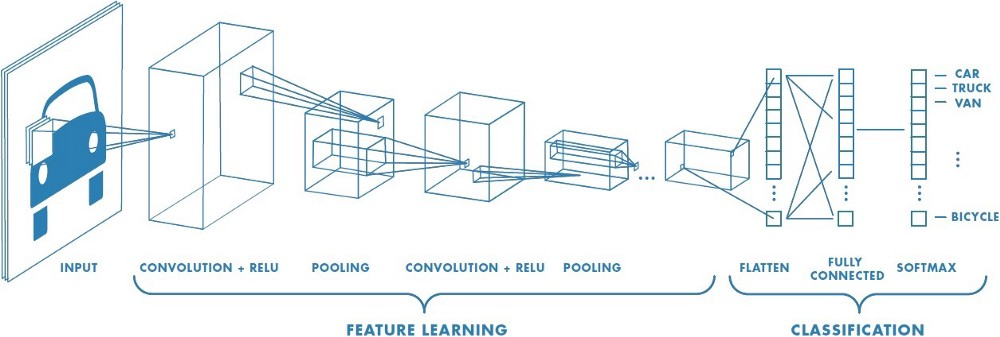
<br/>
<br/>.

There are several popular state-of-the-art CNN architectures. In general, most deep convolutional neural networks are made of a key set of basic layers, including the convolution layer, the sub-sampling layer, dense layers, and the soft-max layer. 
The architectures typically consist of stacks of several convolutional layers and max-pooling layers followed by a fully connected and SoftMax layers at the end. CNN's are typically used for image detection and classification. In this code, I will be using ResNet18.

<a id="2"></a>
<font color="blue" size=+2.5><b>1.2 Installation of Libraries </b></font>

## !pip install fastai
Install FastAI if required. All other libraires used are likely to be installed already - see list below.

<a id="4"></a>
<font color="blue" size=+2.5><b>1.2 Library Import</b></font>

In [2]:
# Standard library imports
import os
from datetime import datetime
from pathlib import Path
import sys
import winsound

# Third-party library imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.exceptions import UndefinedMetricWarning


# FastAI library imports
import fastai                                   ### https://docs.fast.ai/
from fastai import *
from fastai.vision.all import *
from fastai.metrics import error_rate

<a id="4"></a>
<font color="blue" size=+2.5><b>1.3 Confirm Python/Library Versions</b></font>

In [3]:
separator_char_repeat = 150
print('▬' * separator_char_repeat)
print("Python Version:", sys.version)
print("FastAI Version: ",fastai.__version__)
print("Pandas Version:", pd.__version__)
print("NumPy Version:", np.__version__)
print("Matplotlib Version:", matplotlib.__version__)
print("Seaborn Version:", sns.__version__)
print("OpenCV Version:", cv2.__version__)

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Python Version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
FastAI Version:  2.7.14
Pandas Version: 2.1.1
NumPy Version: 1.24.3
Matplotlib Version: 3.8.0
Seaborn Version: 0.12.2
OpenCV Version: 4.9.0


<a id="4"></a>
<font color="blue" size=+2.5><b>2.1 Function to calculate and print elapsed time (with beep sound)</b></font>

In [4]:
def print_elapsed_time(process_step, start_time, end_time):
    """
    Print the elapsed time for a given process step from start_time to end_time in Days, Hours, Minutes, and Seconds.
    
    Parameters:
    - start_time: datetime instance when the timer starts
    - end_time: datetime instance when the timer ends
    - process_step: string describing the process step
    """
    # Calculate the time difference
    time_diff = end_time - start_time

    # Extract days, hours, minutes, and seconds
    days = time_diff.days
    seconds = time_diff.seconds
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60

    # Print the process step and the elapsed time in the specified format
    print(f"▲ Process Step: {process_step}")
    print(f"▲ Elapsed time: {days} Days, {hours} Hours, {minutes} Minutes, {seconds} Seconds")
    # Play a simple beep sound (If running in the backgroundd, useful to alert step complete)
    winsound.Beep(frequency=1000, duration=3000)  # Frequency in Hz, Duration in milliseconds

<a id="5"></a>
<font color="blue" size=+2.5><b>3.1 Setting up path for training and validation data</b></font>

**Point to be Noted: Number of elements in a list of path is same as number of classes you have**

In [5]:
# Get the current working directory
current_path = os.getcwd()
print("Current Path: ", current_path)



Current Path:  C:\Users\seand\OneDrive\Documents\500 - Sean Donohue\Imperial\GitHub\pcmlia_p1


In [6]:
dataset_train_path = r'intel_image_classification\seg_train'
full_dataset_train_path = os.path.join(current_path, dataset_train_path)
print('▬' * separator_char_repeat)
print("Full Dataset Train Path: ", full_dataset_train_path)

# List sub-folders in the full_dataset_train_path
train_sub_folders = [f.name for f in os.scandir(full_dataset_train_path) if f.is_dir()]
print("Sub-folders in the dataset train path:",train_sub_folders)

total_files = 0

# Iterate over each sub-folder
for sub_folder in train_sub_folders:
    # Construct the path to the sub-folder
    folder_path = os.path.join(full_dataset_train_path, sub_folder)
    # List all files in the sub-folder
    files = [f.name for f in os.scandir(folder_path) if f.is_file()]
    # Count the number of files in this sub-folder
    num_files = len(files)
    # Print the number of files with thousands separator
    print(f"Number of files in {sub_folder}: {num_files:,}")
    # Add the count to the total number of files
    total_files += num_files

# Print the total number of files found with thousands separator
print(f"Total number of files found: {total_files:,}")


▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Full Dataset Train Path:  C:\Users\seand\OneDrive\Documents\500 - Sean Donohue\Imperial\GitHub\pcmlia_p1\intel_image_classification\seg_train
Sub-folders in the dataset train path: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Number of files in buildings: 2,191
Number of files in forest: 2,271
Number of files in glacier: 2,404
Number of files in mountain: 2,512
Number of files in sea: 2,274
Number of files in street: 2,382
Total number of files found: 14,034


<a id="5"></a>
<font color="blue" size=+2.5><b>3.2 Setting up path for test data</b></font>

In [7]:
dataset_test_path = r'intel_image_classification\seg_test'
full_dataset_test_path = os.path.join(current_path, dataset_test_path)
print('▬' * separator_char_repeat)
print("Full Dataset Test Path: ", full_dataset_test_path)

# List sub-folders in the full_dataset_test_path
test_sub_folders = [f.name for f in os.scandir(full_dataset_test_path) if f.is_dir()]
print("Sub-folders in the dataset test path:",test_sub_folders)

total_files = 0

# Iterate over each sub-folder
for sub_folder in test_sub_folders:
    # Construct the path to the sub-folder
    folder_path = os.path.join(full_dataset_test_path, sub_folder)
    # List all files in the sub-folder
    files = [f.name for f in os.scandir(folder_path) if f.is_file()]
    # Count the number of files in this sub-folder
    num_files = len(files)
    # Print the number of files with thousands separator
    print(f"Number of files in {sub_folder}: {num_files:,}")
    # Add the count to the total number of files
    total_files += num_files

# Print the total number of files found with thousands separator
print(f"Total number of files found: {total_files:,}")

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Full Dataset Test Path:  C:\Users\seand\OneDrive\Documents\500 - Sean Donohue\Imperial\GitHub\pcmlia_p1\intel_image_classification\seg_test
Sub-folders in the dataset test path: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Number of files in buildings: 437
Number of files in forest: 474
Number of files in glacier: 553
Number of files in mountain: 525
Number of files in sea: 510
Number of files in street: 501
Total number of files found: 3,000


<a id="5"></a>
<font color="blue" size=+2.5><b>3.3 Setting up path for Non-labelled Prediction data (Optional - not used)</b></font>

In [8]:
dataset_predict_path = r'intel_image_classification\seg_pred'
full_dataset_predict_path = os.path.join(current_path, dataset_predict_path)
print('▬' * separator_char_repeat)
print("Full Dataset Predict Path: ", full_dataset_predict_path)

# List sub-folders in the full_dataset_predict_path
predict_sub_folders = [f.name for f in os.scandir(full_dataset_predict_path) if f.is_dir()]
print("Sub-folders in the dataset predict path:", predict_sub_folders)

# Correcting the previous mistake by defining 'predict_files'
# List all files in the directory directly
predict_files = [f.name for f in os.scandir(full_dataset_predict_path) if f.is_file()]

# Count the number of files directly within the directory
total_files = len(predict_files)

# Print the number of files, using thousands separator for readability
print(f"Total number of files found: {total_files:,}")

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Full Dataset Predict Path:  C:\Users\seand\OneDrive\Documents\500 - Sean Donohue\Imperial\GitHub\pcmlia_p1\intel_image_classification\seg_pred
Sub-folders in the dataset predict path: []
Total number of files found: 7,301


<a id="6"></a>
<font color="blue" size=+2.5><b>4.1 Data Loading For training/validation</b></font>
<br/>

**For Noting:**
* Decide validation percentage ( 0.2 => 20% )
* Provide path for training data
* [Decide augmentations criteria (optional)](https://www.kaggle.com/init27/introduction-to-image-augmentation-using-fastai/)
* Decide image size (which is 224 in this case based on ResNet, even though input images are 150x150 pixels)
* Test data can also be added but it's optional (Testing is performed in a separate, later section)

In [9]:
target_image_size = 224         # Pre-trained models, such as ResNet expect input images 224x224 pixels
validation_percentage = 0.2     # Set aside 20% of randomly chosen images for validation/hyperparamter tuning 


data = ImageDataLoaders.from_folder(full_dataset_train_path, train='.', valid_pct=validation_percentage,
                                    item_tfms=Resize(target_image_size), 
                                    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)], 
                                    num_workers=8)

<a id="7"></a>
<font color="blue" size=+2.5><b>4.2 Data Explorations</b></font>
<br/>

*Our image dataset is stored as .jpg files in 2 different folders, with each folder bearing the name of model of the images contained in the folder. We use the ImageDataBunch.from_folder() function to load the images and assign labels the images based on the name of the folder they’re read from.*

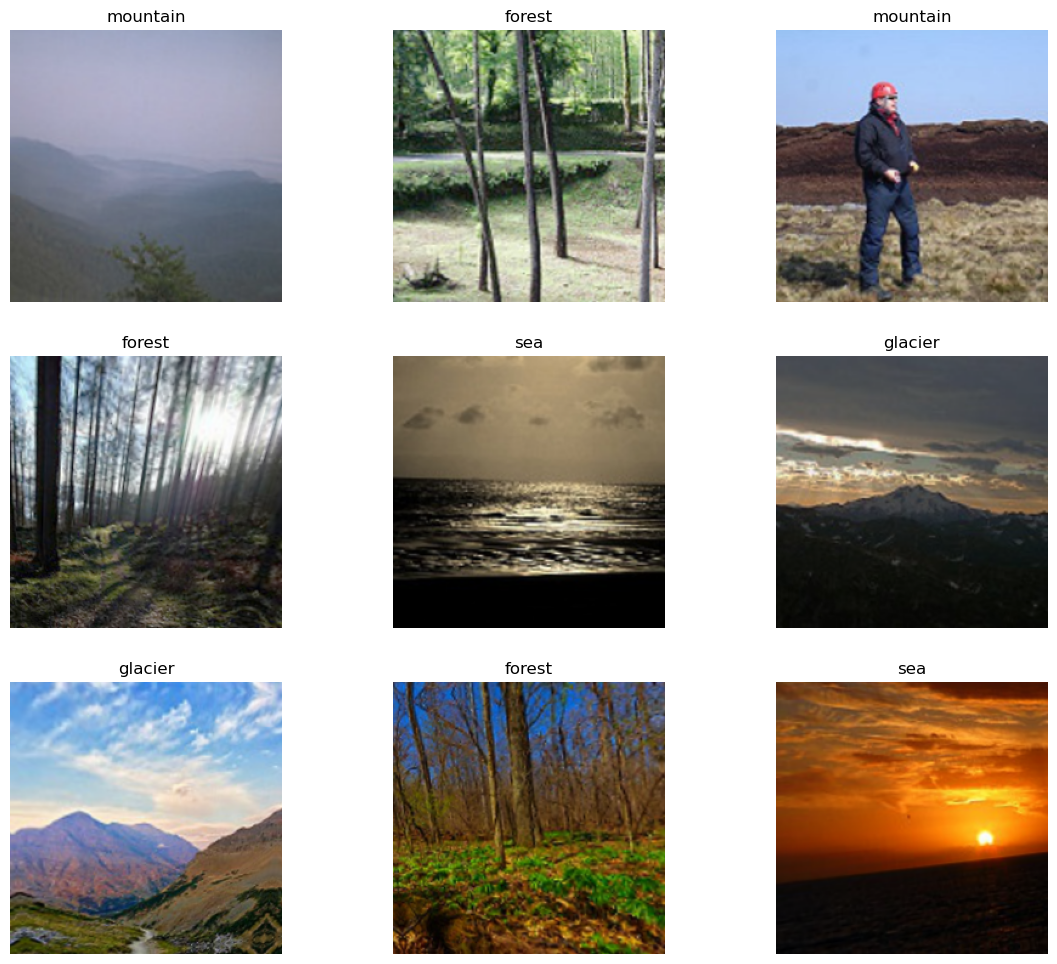

In [10]:
## data.show_batch(nrows=3, figsize=(7,6),recompute_scale_factor=True)
data.show_batch(nrows=3, figsize=(14,12))

<a id="8"></a>
<font color="blue" size=+2.5><b>4.3 Print Classes present in the dataloader</b></font>
<br/>

* Training dataset
* Validation dataset

In [11]:
data

In [12]:
# Print the names of classes and the number of classes
print('▬' * separator_char_repeat)
print("Number of classes:", len(data.vocab))
print("Classes found:", data.vocab)
# Print the number of classes in the dataset

# Function to calculate class distribution
def calculate_class_distribution(dataloader, vocab):
    class_counts = {label: 0 for label in vocab}
    for _, y in dataloader:
        for label in y:
            class_counts[vocab[label]] += 1
    return class_counts

# Calculate and print class distribution for the training set
train_class_distribution = calculate_class_distribution(data.train, data.vocab)
print("Training - Training set class distribution:", train_class_distribution)
# Print the size of the training dataset
print("Training - Total Size of training dataset:", len(data.train_ds))

# Calculate and print class distribution for the validation set
valid_class_distribution = calculate_class_distribution(data.valid, data.vocab)
print("Validation - Validation set class distribution:", valid_class_distribution)
# Print the size of the validation dataset
print("Validation - Total Size of validation dataset:", len(data.valid_ds))

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Number of classes: 6
Classes found: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Training - Training set class distribution: {'buildings': 1739, 'forest': 1803, 'glacier': 1918, 'mountain': 1998, 'sea': 1823, 'street': 1919}
Training - Total Size of training dataset: 11228
Validation - Validation set class distribution: {'buildings': 446, 'forest': 465, 'glacier': 482, 'mountain': 507, 'sea': 447, 'street': 459}
Validation - Total Size of validation dataset: 2806


<a id="9"></a>
<font color="blue" size=+2.5><b>5.1 Create Model</b></font>
<br/>
* We now use a pre-trained ResNet18 Convolutional Neural Net model, and use transfer learning to learn weights of only the last layer of the network.
* Why Transfer learning? Because with transfer learning, you begin with an existing (trained) neural network used for image recognition — and then tweak it a bit (or more) here and there to train a model for your particular use case. And why do we do that? Training a reasonable neural network would mean needing approximately 300,000 image samples, and to achieve really good performance, we’re going to need at least a million images.
* In our case, we have approximately 2500 images in our training set — you have one guess to decide if that would have been enough if were to train a neural net from scratch.
* We use the create_cnn() function for loading a pre-trained ResNet18 network, that was trained on around a million images from the ImageNet database.

In [14]:
print('▬' * separator_char_repeat)
process_step = "Create Model"
start_time = datetime.now()

# Initialize a learner for a computer vision task using a pre-trained ResNet-18 model

model_working_folder = r'model\working'
full_model_working_path = os.path.join(current_path, model_working_folder)

learn = vision_learner(
    data,                                          # Data object containing training and validation datasets
    models.resnet18,                               # Pre-trained model architecture (ResNet-18)
    metrics=[
        accuracy, 
        Precision(average='macro'),                # Adjusted Precision for multi-class, averaged 'macro'
        Recall(average='macro')                    # Adjusted Recall for multi-class, averaged 'macro'
    ],                                             # List of metrics to evaluate during training
    model_dir=full_model_working_path,  # Sub-directory to save model weights
    path=current_path                              # Base path for relative path operations within the learner
)

end_time = datetime.now()
# Print the elapsed time for this process step
print_elapsed_time(process_step, start_time, end_time)

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
▲ Process Step: Create Model
▲ Elapsed time: 0 Days, 0 Hours, 0 Minutes, 0 Seconds


<a id="9"></a>
<font color="blue" size=+2.5><b>5.2 Print Model Summary</b></font>
<br/>
This is an optional step but it provides an overview of your model:
* Layers Description: It lists all the layers in your model, including convolutional layers, batch normalization layers, activation functions, pooling layers, and fully connected layers (linear layers), among others.
* Layer Types and Order: You get to see the types of layers used and their sequence in the model, which is essential for understanding how the model processes input data.
* Output Size: For each layer, it shows the size of its output tensor. This is particularly useful for understanding how the dimensions of the data change as it passes through the model.
* Number of Parameters: It provides the number of trainable parameters for each layer. This information can help you assess the complexity of the model and its capacity to learn from data.
* Total Parameters: The summary includes the total number of parameters, both trainable and non-trainable. This gives an idea of the overall compl and size of the model.el.

 model.
ility

In [15]:
print('▬' * separator_char_repeat)
learn.summary()

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

<a id="10"></a>
<font color="blue" size=+2.5><b>5.3 Finding LR - The Learning Rate (Pre-trained model)</b></font>
<br/>

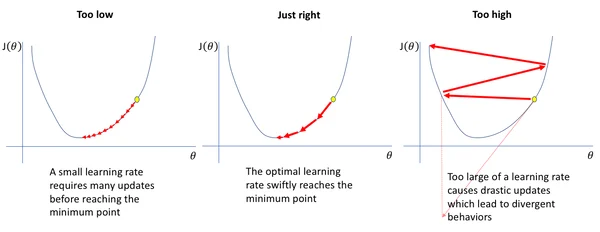

Image source: https://www.jeremyjordan.me/nn-learning-rate/

The following method applies the Learning Rate Finder algorithm, initially proposed by Leslie N. Smith in the paper "Cyclical Learning Rates for Training Neural Networks." It involves training the model for a few epochs while systematically increasing the learning rate from a very small value to a very high value. It tracks how the loss changes as the learning rate increases and typically generates a graph showing the relationship between the learning rate and the loss.

The optimal learning rate is usually a value where the loss is decreasing at a rapid pace before it starts to increase again or becomes unstable.

Suggests a learning rate from the longest valley and returns its index. The valley algorithm (See plot) was developed by ESRI and takes the steepest slope roughly 2/3 through the longest valley in the LR plot, and is also the default for Learner.lr_find.
(A variety of learning rate suggestion algorithms can be passed into the function, by default we use the valley paradigm ).

* Minimum or Minimum/10: This is typically a point with the lowest recorded loss divided by 10. It's often used as a conservative estimate of the upper bound of the learning rate.
* Steepest Point: This is the learning rate where the loss most rapidly decreases, indicating effective learning while minimizing the risk of divergence.
* Valley: This represents a region where the loss is relatively low and stable, suggesting a range where the model can learn effectively.
* Slide: This corresponds to a learning rate where the loss declines steadily, which may be suitable for more gradual and sustained learning.


▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


Minimum/10     : 1.45e-02 (A learning rate that is one-tenth of the learning rate that achieved the lowest loss)
Steepest point : 1.74e-03 (The learning rate where the slope of the loss is steepest)
Valley        : 1.00e-03 (A learning rate within a region where the loss is consistently low)
Slide         : 6.92e-04 (A learning rate at the first point where the loss starts to decline steadily)
▲ Process Step: Finding Learning Rate - Pre-trained model
▲ Elapsed time: 0 Days, 0 Hours, 8 Minutes, 8 Seconds


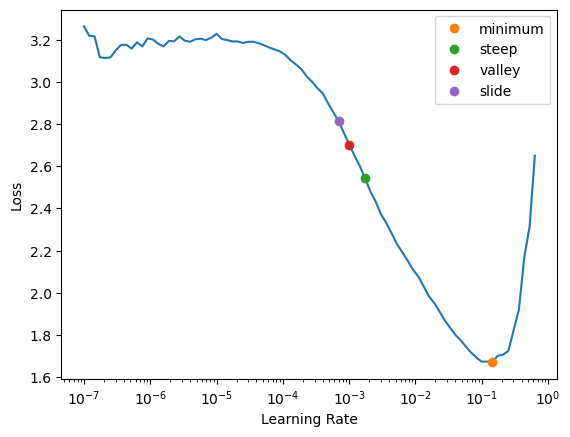

In [16]:
print('▬' * separator_char_repeat)
process_step = "Finding Learning Rate - Pre-trained model"
start_time = datetime.now()

# Find the optimal learning rate using the learning rate finder
# This method tests different learning rates and records the losses at each rate
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

print(f"Minimum/10     : {lr_min:.2e} (A learning rate that is one-tenth of the learning rate that achieved the lowest loss)")
print(f"Steepest point : {lr_steep:.2e} (The learning rate where the slope of the loss is steepest)")
print(f"Valley        : {lr_valley:.2e} (A learning rate within a region where the loss is consistently low)")
print(f"Slide         : {lr_slide:.2e} (A learning rate at the first point where the loss starts to decline steadily)")

end_time = datetime.now()
# Print the elapsed time for this process step
print_elapsed_time(process_step, start_time, end_time)

<a id="11"></a>
<font color="blue" size=+2.5><b>5.4 Train Model</b></font>
<br/>

#### Fit the model using the " One cycle" learning rate policy for the number of epochs as chosen.
The "One cycle" policy is a training method that starts with a lower learning rate, gradually increases it, and then decreases it.
This approach can help in achieving better performance and faster convergence.
#### Parameters:
The number of epochs to train for. An epoch is one complete pass through the entire training dataset.
slice(for example: 1e-4,1e-3): This sets the learning rates for the unfrozen layers.
The first value (for example, 1e-4 or 0.0001) is the starting learning rate for the earliest layers.
The second value (for example, 1e-3 or 0.001) is the learning rate for the last layer.
The layers in between will have learning rates that gradually increase from the first value to the second value.
This technique is known as discriminative learning rates, where earlier layers (which capture more general information)
have smaller learning rates, and later layers (more specific to the current task) have higher learning rates.

* This approach should provide a balance between learning efficiently and not making the earlier layers' weights diverge too much from their pre-trained state.
* Keep in mind that the effectiveness of learning rates can be highly dependent on the specific model and data, so it's often necessary to experiment with a few different settings. 
* Additionally, consider other factors like weight decay, batch size, and the architecture of the model, which can also impact the optimal learning rate.

In [17]:
process_step = "Train Model (Update trainable parameters on pre-trained model)"
start_time = datetime.now()

# For the Resnet18 model, there are Total params: 11,706,944, Total trainable params: 540,032, Total non-trainable params: 11,166,912
# Here we train the model, updating trainable params only. (We will later unfreeze the model and retrain ).

training_epochs = 5    # NB 20 might be a more typical setting, reduced to <= 5 for development purposes

#   learning_rate_layers_earliest = 1e-3         # Based on an earlier code base used
#   learning_rate_layers_last = 1e-1             # Based on an earlier code base used
#   learning_rate_layers_earliest = 5.75e-04     # Based on LR find output   for v10 5 Epochs
#   learning_rate_layers_last = 1.74e-03         # Based on LR find output   for v10 5 Epochs
#   Note: You could, if preferred calculate earning_rate_layers_earliest,learning_rate_layers_last based on lr_min, lr_steep, lr_valley, lr_slide
#   values returned from the lr_find method. Here I have set them based on lr_find values returned in previous runs.

learning_rate_layers_earliest = 1.20e-03  # Slide or Valley, conservative
learning_rate_layers_last = 2.51e-03      # Steepest Point, more aggressive

learn.fit_one_cycle(training_epochs, slice(learning_rate_layers_earliest,learning_rate_layers_last))

end_time = datetime.now()
# Print the elapsed time for this process step
print_elapsed_time(process_step, start_time, end_time)


▲ Process Step: Train Model (Update trainable parameters on pre-trained model)
▲ Elapsed time: 0 Days, 1 Hours, 33 Minutes, 58 Seconds


<a id="12"></a>
<font color="blue" size=+2.5><b>6.1 Hyper Parameter Tuning</b></font>


#### Unfreeze all the layers of the model.
Initially, when using transfer learning, the pre-trained layers are frozen, meaning their weights are not updated during training.
Unfreezing them allows all the layers' weights to be updated during training based on the new data.

In [18]:
print('▬' * separator_char_repeat)
process_step = "Unfreeze Layer Weights"
start_time = datetime.now()

# Before unfreezing - this print is optional and for information only - to see where weights are frozen
print("Before unfreezing:")
for name, param in learn.model.named_parameters():
    print(f"{name}: {param.requires_grad}")

learn.unfreeze()

# After unfreezing - this print is optional and for information only - to see where weights are unfrozen and can be adjusted through training
print("\nAfter unfreezing:")
for name, param in learn.model.named_parameters():
    print(f"{name}: {param.requires_grad}")

end_time = datetime.now()
# Print the elapsed time for this process step
print_elapsed_time(process_step, start_time, end_time)

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Before unfreezing:
0.0.weight: False
0.1.weight: True
0.1.bias: True
0.4.0.conv1.weight: False
0.4.0.bn1.weight: True
0.4.0.bn1.bias: True
0.4.0.conv2.weight: False
0.4.0.bn2.weight: True
0.4.0.bn2.bias: True
0.4.1.conv1.weight: False
0.4.1.bn1.weight: True
0.4.1.bn1.bias: True
0.4.1.conv2.weight: False
0.4.1.bn2.weight: True
0.4.1.bn2.bias: True
0.5.0.conv1.weight: False
0.5.0.bn1.weight: True
0.5.0.bn1.bias: True
0.5.0.conv2.weight: False
0.5.0.bn2.weight: True
0.5.0.bn2.bias: True
0.5.0.downsample.0.weight: False
0.5.0.downsample.1.weight: True
0.5.0.downsample.1.bias: True
0.5.1.conv1.weight: False
0.5.1.bn1.weight: True
0.5.1.bn1.bias: True
0.5.1.conv2.weight: False
0.5.1.bn2.weight: True
0.5.1.bn2.bias: True
0.6.0.conv1.weight: False
0.6.0.bn1.weight: True
0.6.0.bn1.bias: True
0.6.0.conv2.weight: False
0.6.0.bn2.weight: True
0.6.0.

<a id="10"></a>
<font color="blue" size=+2.5><b>6.2 Finding LR - The Learning Rate (Unfrozen model)</b></font>
<br/>

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


Minimum/10     : 3.31e-05 (A learning rate that is one-tenth of the learning rate that achieved the lowest loss)
Steepest point : 6.31e-07 (The learning rate where the slope of the loss is steepest)
Valley        : 7.59e-05 (A learning rate within a region where the loss is consistently low)
Slide         : 4.37e-05 (A learning rate at the first point where the loss starts to decline steadily)
▲ Process Step: Finding Learning Rate - Unfrozen model
▲ Elapsed time: 0 Days, 0 Hours, 7 Minutes, 57 Seconds


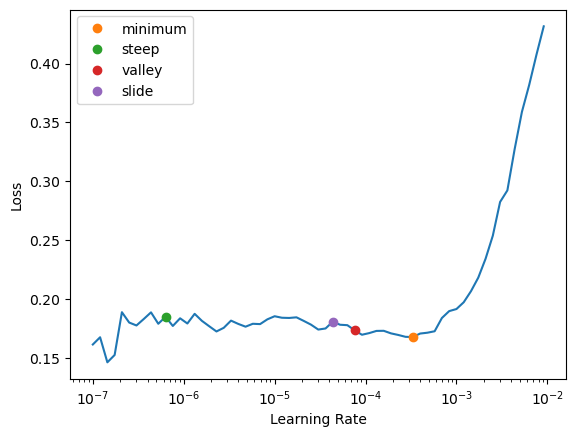

In [19]:
print('▬' * separator_char_repeat)
process_step = "Finding Learning Rate - Unfrozen model"
start_time = datetime.now()

# Find the optimal learning rate using the learning rate finder
# This method tests different learning rates and records the losses at each rate
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

print(f"Minimum/10     : {lr_min:.2e} (A learning rate that is one-tenth of the learning rate that achieved the lowest loss)")
print(f"Steepest point : {lr_steep:.2e} (The learning rate where the slope of the loss is steepest)")
print(f"Valley        : {lr_valley:.2e} (A learning rate within a region where the loss is consistently low)")
print(f"Slide         : {lr_slide:.2e} (A learning rate at the first point where the loss starts to decline steadily)")

end_time = datetime.now()
# Print the elapsed time for this process step
print_elapsed_time(process_step, start_time, end_time)

In [22]:
process_step = "One cycle training - Unfrozen Model"
start_time = datetime.now()

tuning_epochs = 5   ### NB 20 may be a typical setting, reduced to <=5 for development purposes

learning_rate_layers_earliest = lr_min             # Generally recommended to choose a learning rate at or slightly below the "Minimum/10" 
learning_rate_layers_last = lr_valley              # A learning rate within a region where the loss is consistently low

learn.fit_one_cycle(tuning_epochs, slice(learning_rate_layers_earliest,learning_rate_layers_last))

end_time = datetime.now()
# Print the elapsed time for this process step
print_elapsed_time(process_step, start_time, end_time)

▲ Process Step: One cycle training - Unfrozen Model
▲ Elapsed time: 0 Days, 1 Hours, 53 Minutes, 9 Seconds


<a id="10"></a>
<font color="blue" size=+2.5><b>6.3 Plot Loss (Unfrozen model)</b></font>
<br/>

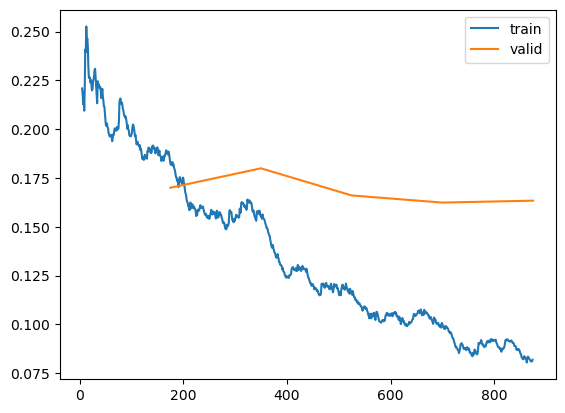

In [23]:
learn.recorder.plot_loss()

Axes of the Graph:
X-axis: Represents the training iterations or batches. If the number of iterations is high, it may represent the number of epochs (complete passes through the entire training dataset) Here the validation points on the graph represent one epoch. .
Y-axis: Represents the loss value. This is a measure of how well the model is performing; lower values indicate better performance.
Interpretation of the Graph:
Training Loss (Blue Line): This shows how the model's loss decreases as it learns from the training dataset. Fluctuations can occur due to the stochastic nature of the optimization algorithm (usually stochastic gradient descent or its variants). Ideally, this should trend downwards as the model becomes better at predicting the training data.

Validation Loss (Orange Line): This shows the loss calculated on a separate dataset that is not used for training (the validation In this case, we set aside 20% of the training data to use for valdiation). set). This is a good indicator of how well the model is generalizing to unseen data. Unlike the training loss, the validation loss is not directly used for updating the model's weights and is typically evaluated at the end of each epoch.

Key Observations:
If the training loss is decreasing but the validation loss starts to increase, it could be a sign of overfitting, meaning the model is learning to predict the training data too well, including noise or patterns that don't generalize to ns uncommon. Typically, you'd expect the validation loss to be higher than the training loss because the model is trained on the training data, not the vali as t such as:
The validation set is easier for the model to predict than the training set.
Different data preprocessing or augmentation is applied to the training set but not the validation set.
Dropout or other regularization techniques that are only active during training (which can cause higher training loss as the model's effective capacity is reduced).
In general, you want both the training and validation loss to decrease and stabilize. However, it's the validation loss that you should monitor more closely for the reasons stated above.

<a id="13"></a>
<font color="blue" size=+2.5><b>6.4 Interpret the results (Unfrozen model)</b></font>

Model performance can be validated in different ways. One of the popular methods is using the confusion matrix. Diagonal values of the matrix indicate correct predictions for each class, whereas other cell values indicate a number of wrong predictions. The following metrics are reported: 

* Validation Loss: A measure of how well the model is performing on a separate dataset that was not used during training, known as the validation set. The loss typically represents the model's error; lower values are better. In classification tasks, this might be the cross-entropy loss.

* Accuracy: The ratio of the correctly predicted observations to the total observations. It gives you the fraction of predictions our model got right. For example, An accuracy of 0.9365 means that approximately 93.65% of the model's predictions are correct.

* Precision Score: The ratio of correctly predicted positive observations to the total predicted positive observations. It is a measure of a classifier's exactness. High precision indicates a low rate of false-positive predictions. For example, a precision score of 0.9371 means that when the model predicts a positive class, it is correct about 93.71% of the time.

* Recall Score: Recall (also known as sensitivity or true positive rate) is the ratio of correctly predicted positive observations to all observations that are actually positive. It is a measure of a classifier's completeness. High recall indicates that the class is correctly recognised (a low number of false negatives). For example, a recall score of 0.9383 means that the model correctly identified about 93.83% of the actual positive cases.

▲ Process Step: Interpret Results/Confusion Matrix
▲ Elapsed time: 0 Days, 0 Hours, 3 Minutes, 47 Seconds


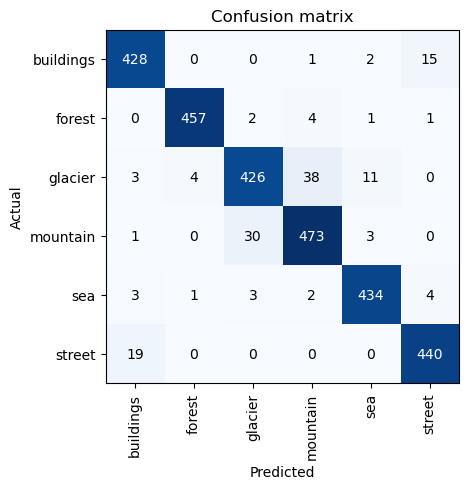

In [24]:
process_step = "Interpret Results/Confusion Matrix"
start_time = datetime.now()

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

end_time = datetime.now()
# Print the elapsed time for this process step
print_elapsed_time(process_step, start_time, end_time)

In [25]:
# Validate the model and print the results
validation_results = learn.validate()

# The first value is always the validation loss
val_loss = validation_results[0]

# The remaining values are the metrics
val_metrics = validation_results[1:]

print('▬' * separator_char_repeat)
print(f'Validation Loss: {val_loss}')
# Print each metric value
for i, metric in enumerate(learn.metrics):
    print(f'{metric.name}: {val_metrics[i]}')

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Validation Loss: 0.16336244344711304
accuracy: 0.9472559094429016
precision_score: 0.9479903327951495
recall_score: 0.9481193547284305


<a id="13"></a>
<font color="blue" size=+2.5><b>6.5 Print images with highest loss/worst predictions</b></font>

#### Method interp.plot_top_losses is a function from the FastAI library
When you run this function, it will output a plot with the specified number of images. For each of these images, it will show:
The predicted class.
The actual class.
The loss associated with the prediction.
The probability assigned to the predicted class.

You should notice (a) some 'noise' - images incorectly labelled (do not belong to any of the classes) and (b) some images that are intuitively difficult to classify or arbitrary, e.g., may contain some sea and some mountain in similar proportions.

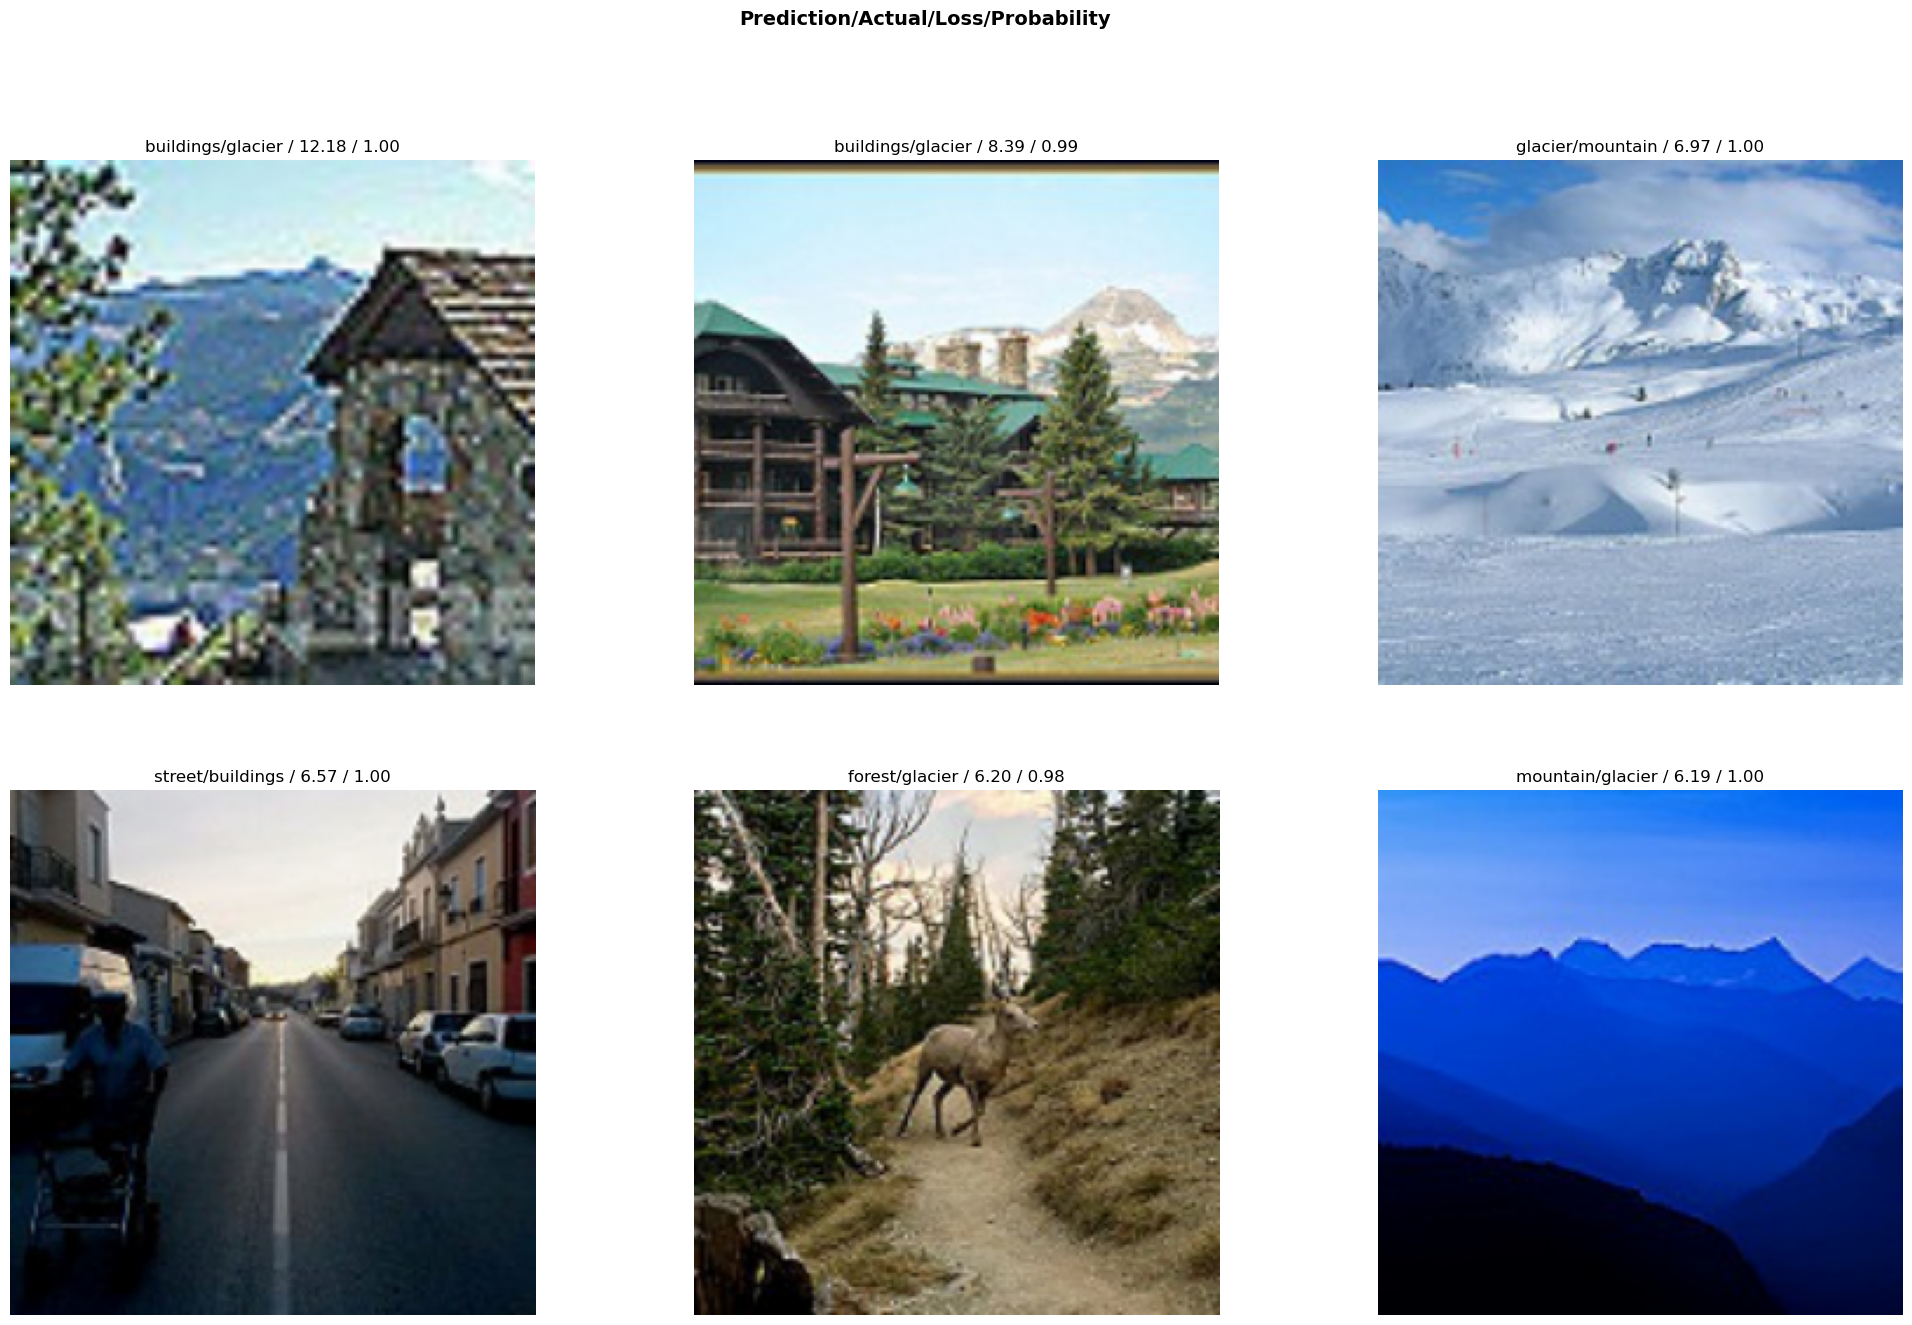

In [26]:
# Suppress only UndefinedMetricWarnings
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

# Print the first n number of images with highest loss
number_images_to_plot = 6
interp.plot_top_losses(number_images_to_plot,figsize = (25,15))

<a id="14"></a>
<font color="blue" size=+2.5><b>6.6 Sample prediction Using Trained Model</b></font>

In [27]:
print('▬' * separator_char_repeat)
# Construct the path to the image you want to predict
image_path = os.path.join(full_dataset_test_path, 'glacier', '21982.jpg')

# Open the image using FastAI's method (ensure you use the correct function based on your version of FastAI)
img = PILImage.create(image_path)

# Use the model to predict the class of the image
prediction = learn.predict(img)
print(prediction[0])  # This will print the predicted class label


▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


glacier


<a id="14"></a>
<font color="blue" size=+2.5><b>7.1 Test the model on unseen data (test dataset)</b></font>

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Test Dataset Path:  C:\Users\seand\OneDrive\Documents\500 - Sean Donohue\Imperial\GitHub\pcmlia_p1\Intel_Image_Classification\seg_test
Test - Creating Dataloader for Test Dataset
Test - Number of images loaded: 3000
Test - Number of batches: 47
Test - Creating Interpretation Object


Test - Plotting Confusion Matrix


▲ Process Step: Test Model on unseen data from test dataset
▲ Elapsed time: 0 Days, 0 Hours, 4 Minutes, 5 Seconds


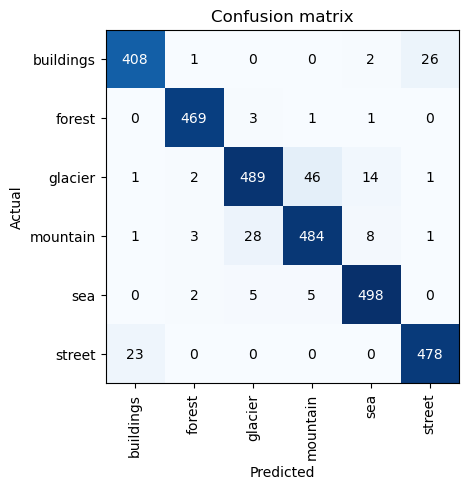

In [28]:
process_step = "Test Model on unseen data from test dataset"
start_time = datetime.now()
print('▬' * separator_char_repeat)

# Import the required functions from sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Specify the test dataset path
full_dataset_test_path = r"C:\Users\seand\OneDrive\Documents\500 - Sean Donohue\Imperial\GitHub\pcmlia_p1\Intel_Image_Classification\seg_test"
print("Test Dataset Path: ", full_dataset_test_path)

# Assuming 'learn' is your trained learner object

# Create a DataLoader for the test dataset and run it through the model
print("Test - Creating Dataloader for Test Dataset")
test_dataloader = learn.dls.test_dl(get_image_files(full_dataset_test_path), with_labels=True)
# Get the number of items in the test DataLoader
num_items = len(test_dataloader.dataset)
print(f"Test - Number of images loaded: {num_items}")
# Optionally, get the number of batches in the test DataLoader
num_batches = len(test_dataloader)
print(f"Test - Number of batches: {num_batches}")

# Create an interpretation object from the learner with the predictions and targets
print("Test - Creating Interpretation Object")
interp = ClassificationInterpretation.from_learner(learn, dl=test_dataloader)

# Plot the confusion matrix using the interpretation object
print("Test - Plotting Confusion Matrix")
interp.plot_confusion_matrix()

end_time = datetime.now()
# Print the elapsed time for this process step
print_elapsed_time(process_step, start_time, end_time)

<a id="15"></a>
<font color="blue" size=+2.5><b>8.1 Save the trained Model</b></font>

In [29]:
# Define the model directory relative to current_path
model_dir = os.path.join(current_path, 'model')

# Create the model directory if it does not exist
os.makedirs(model_dir, exist_ok=True)

Method in FastAI, you are creating an actual .pkl (pickle) file. This file is a binary file that contains the serialized version of the Learner object from FastAI.

The .pkl file created by the export method include: 

* The architecture of the model.
* The trained parameters (weights and biases).
* The state of the optimizer (if it was saved with the model).
* The DataLoaders, including the class to index mapping, transformations, and other preprocessing information.

This file can be used to quickly load the trained model with FastAI's load_learner function for inference without needing to redefine the model architecture or the DataLoader. It's particularly useful for deployment or sharing models, as the receiver of the .pkl file can easily use the model without needing to know how it was constructed or trained.

In [30]:
# Export the learner to the model directory with the correct argument name
learn.export(fname = Path(model_dir) / "cnn_image_class_model_1.pkl")


In [31]:
# Set the model directory in the learner
learn.model_dir = Path(model_dir)

# Save the learner's model
model_path = learn.save("cnn_image_class_model_1", with_opt=False)  # If return_path=True causes an error, remove it

# Print the model's saved path for confirmation
print('▬' * separator_char_repeat)
print(f"Model saved to: {model_path}")

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Model saved to: C:\Users\seand\OneDrive\Documents\500 - Sean Donohue\Imperial\GitHub\pcmlia_p1\model\cnn_image_class_model_1.pth


<a id="16"></a>
<font color="blue" size=+2.5><b>9.1 Sources (hyperlinks)</b></font>
* [Fastai MOOC](https://course.fast.ai/)
* [Fastai library](https://docs.fast.ai/)

<a href="#top" class="btn btn-success btn-lg active" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go to TOP</a>